# 2D Neural Style Transfer with separating BN std according to frequency

This is the Jupyter Notebook for 2D neural style transfer which only applies style loss based on batch normalization statistics. Particularly, the BN std is separated into high frequency part and low frequency part, and loss is computed for both parts.

This notebook can be directly run on Google Colab without additional effort. For acceleration it is helpful to use a GPU runtime.

## Step 0: imports

In [1]:
import sys
import torch
import matplotlib.pyplot as plt

# install KeOps kernels
!pip install -q pykeops==1.4.1 # > install.log

# install pytorch version of np.Interp, which is used for histogram loss
!pip install -q git+https://github.com/aliutkus/torchinterp1d.git

# Please run the following two lines DEPENDENTLY! (depends on whether the notebook is run locally or on Colab)
!git clone https://github.com/wmd0701/MA.git NST
%cd NST

# import self-defined functions
from utils.data_loader import image_loader, image_unloader
from utils.pipeline import pipeline_2D_NST_SepFreq
from utils.plot import plot_statistics, plot_spectrum

# better plot
%pylab inline

     |████████████████████████████████| 319 kB 4.4 MB/s 
Cloning into 'NST'...
remote: Enumerating objects: 205, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 205 (delta 95), reused 147 (delta 39), pack-reused 0
Receiving objects: 100% (205/205), 32.90 MiB | 36.98 MiB/s, done.
Resolving deltas: 100% (95/95), done.
/content/NST
PyTorch3D not installed! Ignore this message if running 2D NST.
PyTorch3D not installed! Ignore this message if running 2D NST.
PyTorch3D not installed! Ignore this message if running 2D NST.
Populating the interactive namespace from numpy and matplotlib


## Step 1: set up configs

In [14]:
# common settings for all configs
style_layers = ['conv1_1', 'conv3_1', 'conv4_1']
style_weights = [1e6/n**2 for n in [64,256,512]]
model_pooling = 'max'
n_iters = 200
learning_rate = 1

# configs
configs = [# config 0
           {'image_path':'starry_night.jpg', 'imsize':256, 'tiling':1, 
            'freq_threshold': 1e-10, 'mean_weight': 1,
            'std_high_freq_weight': 1,
            'std_low_freq_weight': 1,
            },
           
           # config 1
           {'image_path':'starry_night.jpg', 'imsize':256, 'tiling':1,
            'freq_threshold': 1e-10, 'mean_weight': 1,
            'std_high_freq_weight': 100,
            'std_low_freq_weight': 1,
            },
           
           # config 2
           {'image_path':'starry_night.jpg', 'imsize':256, 'tiling':1,
            'freq_threshold': 1e-10, 'mean_weight': 1,
            'std_high_freq_weight': 1,
            'std_low_freq_weight': 100,
            },
           
           ]

## Step 2: run neural style transfer pipeline

In [15]:
# dictionaries of BN means / stds, and list of output images
means = {config_idx : {} for config_idx in range(len(configs))}
stds_high_freq  = {config_idx : {} for config_idx in range(len(configs))}
stds_low_freq  = {config_idx : {} for config_idx in range(len(configs))}
output_imgs = []

config_idx = 0
for config in configs:
    # read params from config
    image_path = config.get('image_path', 'starry_night.jpg')
    imsize = config.get('imsize', None)
    tiling = config.get('tiling', 1)
    freq_threshold = config.get('freq_threshold', 1e-10)
    mean_weight = config.get('mean_weight', 1)
    std_high_freq_weight = config.get('std_high_freq_weight', 1)
    std_low_freq_weight = config.get('std_low_freq_weight', 1)

    # images
    style_img = image_loader("./image_style/"+image_path, imsize=imsize, tiling=tiling)
    input_img = torch.rand((1,3,256,256), device=style_img.device)

    # pipeline
    output_img, style_losses = pipeline_2D_NST_SepFreq( style_img = style_img, 
                                                        input_img = input_img,
                                                        n_iters = n_iters,
                                                        style_weights = style_weights,
                                                        style_layers = style_layers,
                                                        learning_rate = learning_rate,
                                                        model_pooling = model_pooling,
                                                        silent = True,
                                                        freq_threshold = freq_threshold,
                                                        mean_weight = mean_weight,
                                                        std_high_freq_weight = std_high_freq_weight,
                                                        std_low_freq_weight = std_low_freq_weight
                                                        )

    # add output image
    output_imgs.append(image_unloader(output_img))                          

    # add statistics
    for style_layer_idx in range(len(style_layers)):
        style_layer_str = style_layers[style_layer_idx]
        means[config_idx][style_layer_str] = style_losses[style_layer_idx].target_mean.detach().cpu()
        stds_high_freq[config_idx][style_layer_str] = style_losses[style_layer_idx].target_std_high_freq.detach().cpu()
        stds_low_freq[config_idx][style_layer_str]  = style_losses[style_layer_idx].target_std_low_freq.detach().cpu()
    
    config_idx += 1

run [20]:
run [40]:
run [60]:
run [80]:
run [100]:
run [120]:
run [140]:
run [160]:
run [180]:
run [200]:
run [220]:
run [20]:
run [40]:
run [60]:
run [80]:
run [100]:
run [120]:
run [140]:
run [160]:
run [180]:
run [200]:
run [220]:
run [20]:
run [40]:
run [60]:
run [80]:
run [100]:
run [120]:
run [140]:
run [160]:
run [180]:
run [200]:
run [220]:


## Step 3: plots

### plot style reconstructions

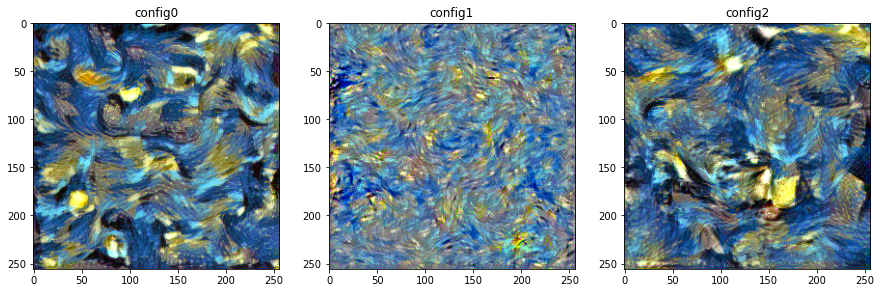

In [16]:
plt.figure(figsize=(5*len(output_imgs), 5))
for i in range(len(output_imgs)):
    plt.subplot(1, len(output_imgs), i+1)
    plt.imshow(output_imgs[i])
    plt.title('config' + str(i))

### plot BN mean / std

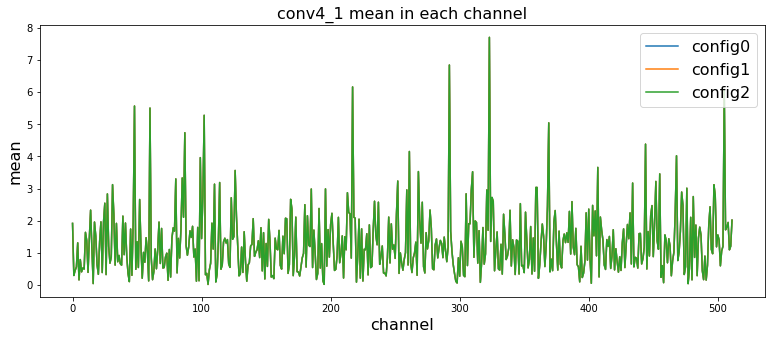

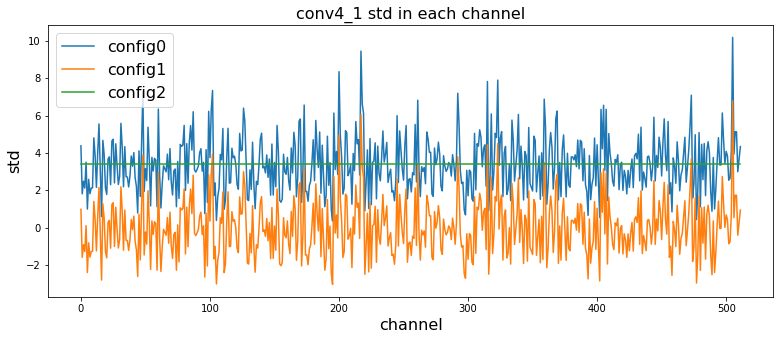

In [17]:
plot_statistics(means, config_idx = None, style_layer = 'conv4_1', title = 'mean')
plot_statistics(stds_high_freq,  config_idx = None, style_layer = 'conv4_1', title = 'std_high_freq')
plot_statistics(stds_low_freq,  config_idx = None, style_layer = 'conv4_1', title = 'std_low_freq')

### plot spectrums

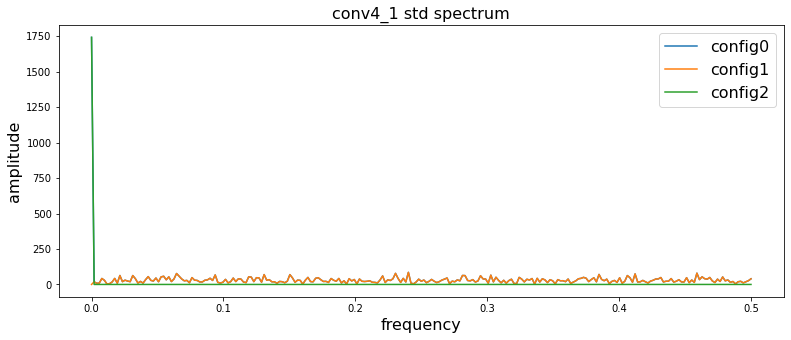

In [18]:
plot_spectrum(stds_high_freq,  config_idx = None, style_layer = 'conv4_1', title = 'std_high_freq')
plot_spectrum(stds_low_freq,  config_idx = None, style_layer = 'conv4_1', title = 'std_low_freq')